# Neural Style Transfer

Implementation of Neural Style Transfer algorithm as proposed by Leon Gatys et al. in “[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)”.

> Note: The original authors used a [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) optimizer, but we used [Adam](https://arxiv.org/abs/1412.6980) optimization instead.

The paper outlines an algorithm for merging the content of one image with the style of another image using convolutional neural networks (CNN). Below is an example that reimagines a photograph of Erykah Badu in the style of Pablo Picasso using a pretrained VGG19 CNN network:

<br>

Stylized Image |
:----------------------------------------------------------:|
  <img src="https://raw.githubusercontent.com/Bashkeel/neural-style-transfer/main/Images/stylized-image.png" />

<br>

</center>

The input images used were as follows:

<br>


Content Image              |  Style Image
:-------------------------:|:-------------------------:
<img src="https://raw.githubusercontent.com/Bashkeel/neural-style-transfer/main/Images/content-image.png" />  |  <img src="https://raw.githubusercontent.com/Bashkeel/neural-style-transfer/main/Images/style-image.png" />
The Queen of Neo-Soul, Erykah Badu | "Girl before a Mirror" by Pablo Picasso

<br>

## Tuneable Parameters

In [1]:
"""
Choose intermediate layers from the pretrained VGG19 network to represent the 
style and content of the image. The early layers represent low-level features
such as edges and textures. The final few layers represent higher-level features
such as wheels or eyes.
"""
content_layers = ['block4_conv2',
                'block5_conv2'] 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block4_conv2',
                'block5_conv1']

"""
We use an Adam optimizer to calculate the mean square error of the generated 
image relative to both the content and style image. Once we have the loss of the
generated image relative to the content and style images, we take the weighted 
sum of the losses. We add an explicit regularization term called the total 
variation loss.
"""
learning_rate=0.02
beta_1=0.99
epsilon=1e-1

style_weight = 5e2
content_weight = 5
total_variation_weight = 2e2

epochs = 20
steps_per_epoch = 100


## Libraries

In [2]:
import os
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

## Required Functions 

In [3]:
# Converts a numeric tensor array into an image
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


# Loads an image and limits its maximum dimension to 512 pixels
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img


# Displays the image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)


# Creates a VGG19 model that returns a list of intermediate output values
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model


# Calculates the gram matrix
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


# Constrains the values of the pixel values between [0,1]
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


# Build a model that returns the style & content tensors (script workhorse)
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}


# Creates a weighted loss function of the style loss and content loss
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss


# Perform one step of the gradient descent and update the image
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
      outputs = extractor(image)
      loss = style_content_loss(outputs)
      loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))


# Will add color preservation strategy as described in "Preserving Color in 
# Neural Style Transfer" by Gatys et al. (https://arxiv.org/abs/1606.05897)
    #import cv2
    #def keep_luminance(image):
    #    image = np.float32(tf.squeeze(image))
    #    image = image[:,:,(2,1,0)]
    #    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    #    image[:,:,0:2] = content_lum
    #    image = cv2.cvtColor(image, cv2.COLOR_YUV2RGB)
    #    image = image[tf.newaxis, :]
    #    return image

## Building the Model 

319488/312209 [==============================] - 0s 1us/step


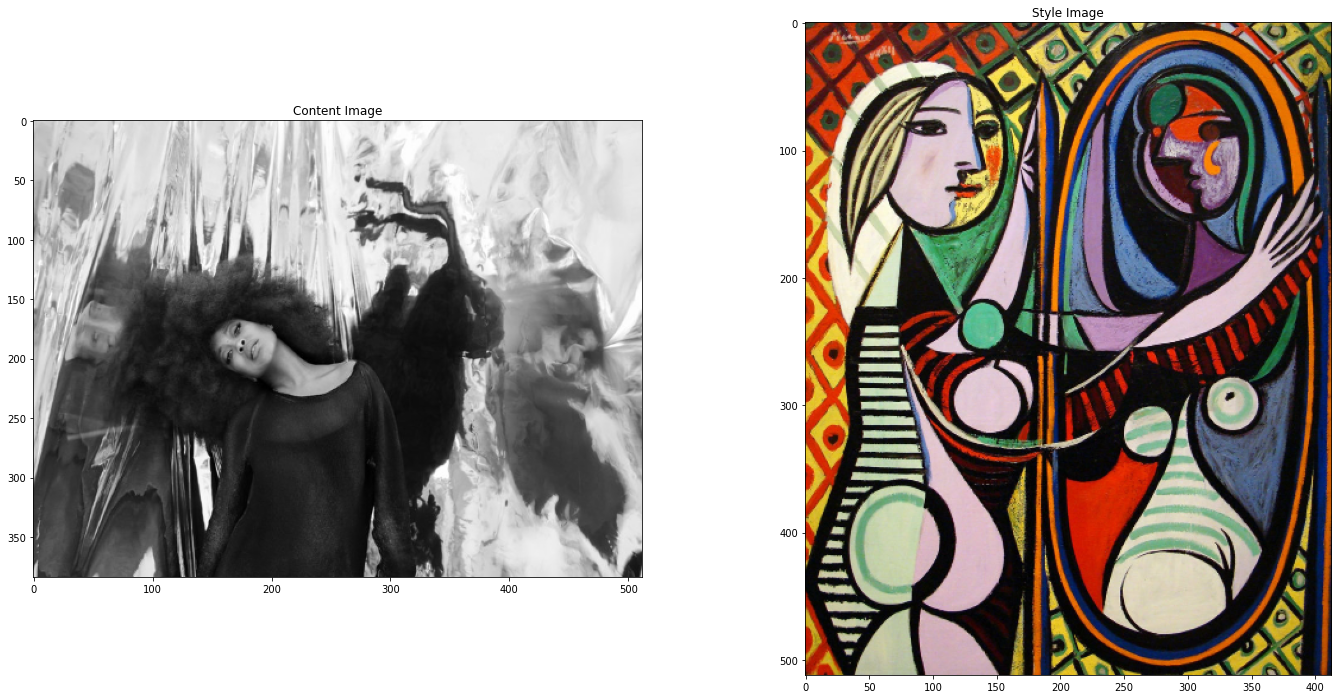

In [4]:
# Choose the style & content images
content_path = tf.keras.utils.get_file('erykah.jpg', 'https://epmgaa.media.clients.ellingtoncms.com/img/photos/2015/06/12/Erykah_Badu_Courtesy_of_Hennessy_t750x550.jpg?d885fc46c41745b3b5de550c70336c1b382931d2')
style_path = tf.keras.utils.get_file('girlbeforeamirror.jpg','https://forums.fast.ai/uploads/default/original/1X/e6a326e5698918fcebd33e267be13748cdc3f055.jpg')

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(24,12))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [5]:
# Load the VGG19 architecture and extract layer names
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [6]:
# Create the VGG19 model & required variables
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

stylized_image = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, epsilon=epsilon)

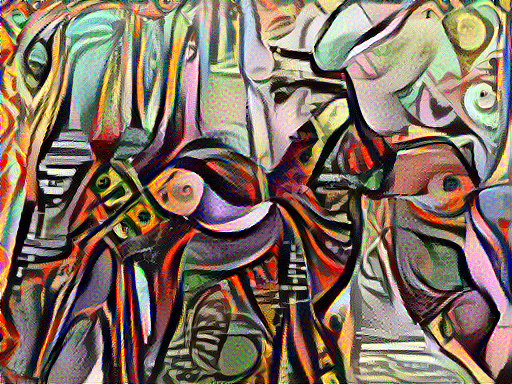

Train step: 2000
Total time: 73.8


In [7]:
# Optimization
start = time.time()

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(stylized_image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(stylized_image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [8]:
# Save the resulting image

file_name = 'stylized-image.png'
tensor_to_image(stylized_image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>